In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pickle
from copy import deepcopy
from pathlib import Path

import gurobipy
from gurobipy import GRB
import dgl
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.problem import get_model, get_soc, load_instance
from src.dataset import InstanceEarlyFixingDataset
from src.net import InstanceGCN
from src.utils import load_from_wandb

In [4]:
instances = list(Path('../data/raw').glob('97_9*.jl'))[-2:]  # test instances only

with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

net = InstanceGCN(2, readout_op=None)
net = load_from_wandb(net, '551sykdm', 'sat-gnn', 'model_last')
net.eval()

opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=10,
)
g1 = ds.gs[0]
g2 = ds.gs[1]

x1_opt = torch.from_numpy(opts[0])
x2_opt = torch.from_numpy(opts[1])

g1, g2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


(Graph(num_nodes={'con': 8211, 'soc': 291, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 110678, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 110678},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 8225, 'soc': 291, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 103224, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 103224},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

In [5]:
def create_batch(g, xs):
    g_batch = list()
    for x in xs:
        g_ = deepcopy(g)
        curr_feats = g_.nodes['var'].data['x']
        g_.nodes['var'].data['x'] = torch.hstack((
            # unsqueeze features dimension, if necessary
            curr_feats.view(curr_feats.shape[0],-1),
            x.view(x.shape[-1],-1),
        ))
        g_batch.append(g_)
    return dgl.batch(g_batch)

x1s = torch.randint(0, 2, (200, 1746))
g1_batch = create_batch(g1, x1s)

x2s = torch.randint(0, 2, (200, 1746))
g2_batch = create_batch(g2, x2s)

g1_batch, g2_batch

(Graph(num_nodes={'con': 1642200, 'soc': 58200, 'var': 349200},
       num_edges={('con', 'c2s', 'soc'): 155000, ('con', 'c2v', 'var'): 22135600, ('soc', 's2c', 'con'): 155000, ('var', 'v2c', 'con'): 22135600},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 1645000, 'soc': 58200, 'var': 349200},
       num_edges={('con', 'c2s', 'soc'): 155000, ('con', 'c2v', 'var'): 20644800, ('soc', 's2c', 'con'): 155000, ('var', 'v2c', 'con'): 20644800},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

[0, 3, 117, 284, 569, 1746] [1, tensor(1.), tensor(0.9573), tensor(0.9648), tensor(0.9649), tensor(0.7778)]
[0, 9, 132, 294, 495, 1746] [1, tensor(1.), tensor(0.9773), tensor(0.9694), tensor(0.9515), tensor(0.7881)]


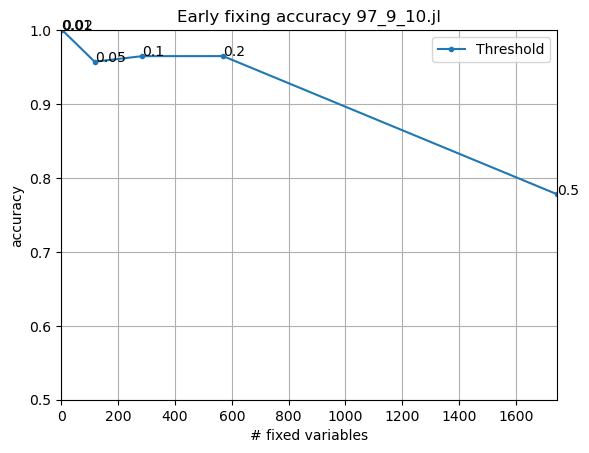

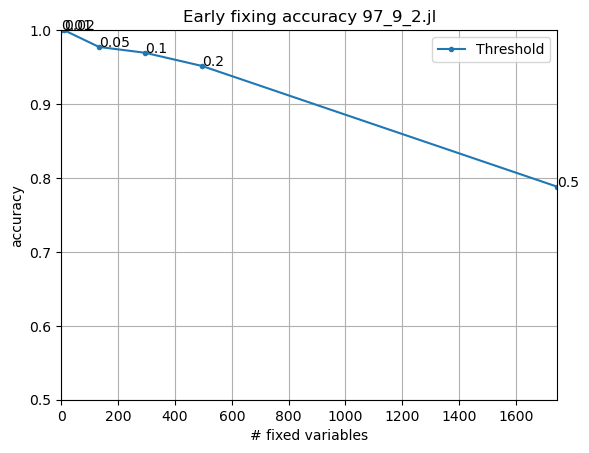

In [6]:
def get_ef_accuracy(g_batch, xs, x_opt, name=None, plot=True):
    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
    err = (x_hat - x_opt).abs()

    thresholds = [.01, .02, .05, .1, .2, .5]

    accs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)
        if most_certain.sum() == 0:
            accs.append(1)
            ns.append(0)
            continue
        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
        fixed_x_opt = x_opt[most_certain]

        acc = (fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0]

        accs.append(acc)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, accs, '.-', label='Threshold')
        ax.set_xlim((0, x_opt.shape[0]))
        ax.set_ylim((.5, 1.))
        ax.grid()
        ax.legend()

        ax.set_title('Early fixing accuracy '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('accuracy')

        for i, thresh in enumerate(thresholds):
            ax.annotate(thresh, (ns[i], accs[i]))

        fig.show()
    
    return thresholds, ns, accs

_, n1s, acc1s = get_ef_accuracy(g1_batch, x1s, x1_opt, name=instances[0].name)
print(n1s, acc1s)
_, n2s, acc2s = get_ef_accuracy(g2_batch, x2s, x2_opt, name=instances[1].name)
print(n2s, acc2s)

### Early Fixing Time Reduction

In [7]:
instances

[PosixPath('../data/raw/97_9_10.jl'), PosixPath('../data/raw/97_9_2.jl')]

In [11]:
instance = instances[0]
print(instance.name)
model = get_model(list(range(9)), instance, coupling=True)
# model.Params.LogToConsole = 1
# model.setParam('TimeLimit', 5 * 60)
model.setParam('MIPGap', .05)
model.update()
model.optimize()
print(model.Runtime)
print(model.ObjVal)

instance = instances[1]
print(instance.name)
model = get_model(list(range(9)), instance, coupling=True)
# model.Params.LogToConsole = 1
# model.setParam('TimeLimit', 5 * 60)
model.setParam('MIPGap', .05)
model.update()
model.optimize()
print(model.Runtime)
print(model.ObjVal)

97_9_10.jl
2.3441998958587646
2785.0
97_9_2.jl
50.43576002120972
3064.0


([0.0, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 3, 117],
 [2.3931961059570312, 6.244985818862915, 2.3991270065307617],
 [2785.0, 2786.0, 2782.0])

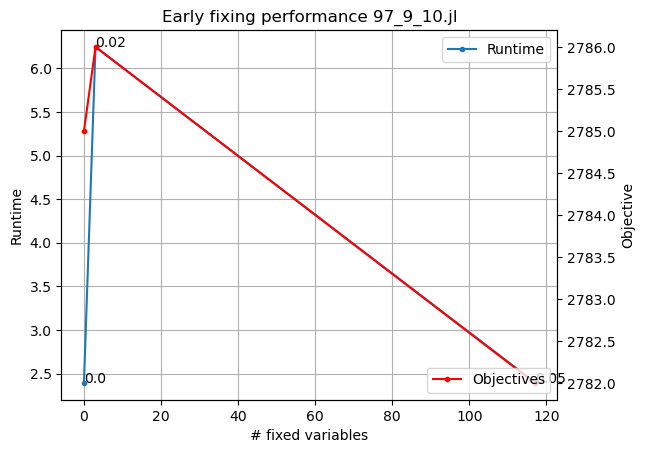

In [8]:
def get_ef_times(g_batch, xs, instance, name=None, plot=True, gap=.05):
    if isinstance(instance, str) or isinstance(instance, Path):
        instance = load_instance(instance)

    jobs = list(range(instance['jobs'][0]))
    model = get_model(jobs, instance, coupling=True, new_ineq=False)
    model.setParam('MIPGap', gap)
    model.update()

    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal

    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution

    thresholds = [0., .02, .05, .1, .2, .5]
    # thresholds = [0., .01, .02, .05, .1]

    runtimes = list()
    objs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) > 1 - thresh)

        if most_certain.sum() == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            ns.append(0)
            continue

        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_hat)

        fixed_vars_names = vars_names[most_certain]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).lb = fixed_var_X
            model_.getVarByName(fixed_var_name).ub = fixed_var_X

        model_.update()
        model_.optimize()

        if model_.status == 3:
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objectives')
        obj_ax.legend(loc=4)
        obj_ax.set_ylabel('Objective')

        for i, n in enumerate(ns):
            ax.annotate(thresholds[i], (n, runtimes[i]))

        fig.show()

    return thresholds, ns, runtimes, objs

get_ef_times(g1_batch, x1s, instances[0], name=instances[0].name)

([0.0, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 9, 132],
 [51.143004179000854, 34.22650194168091, 61.912776947021484],
 [3064.0, 3064.0, 2871.0])

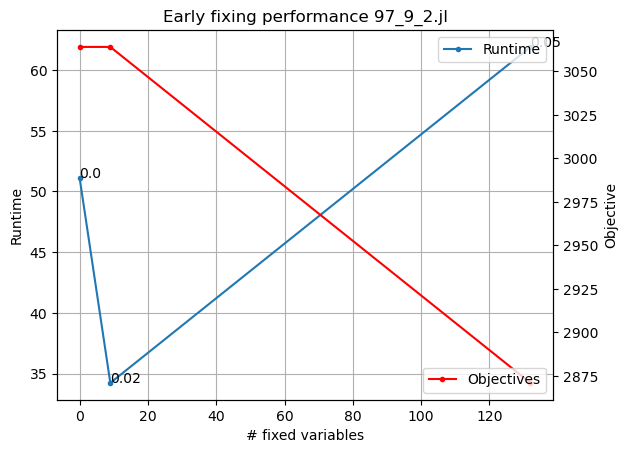

In [9]:
get_ef_times(g2_batch, x2s, instances[1], name=instances[1].name)

In [30]:
g_batch = g1_batch
xs = x1s
x_opt = x1_opt
model = get_model(list(range(9)), instances[0], coupling=True)

vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

with torch.no_grad():
    y_hat = torch.sigmoid(net(g_batch))

y_flip = 1 - y_hat
x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
err = (x_hat - x_opt).abs()

In [31]:
model = get_model(list(range(9)), instances[1], coupling=True)

vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

thresh = .2
most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)

fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
fixed_x_opt = x_opt[most_certain]

fixed_vars_names = vars_names[most_certain]

# fix variables
for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
    model.getVarByName(fixed_var_name).lb = fixed_var_X
    model.getVarByName(fixed_var_name).ub = fixed_var_X

model.setParam('MIPGap', .05)
model.update()
model.optimize()
print(model.Runtime)
print(model.ObjVal)

0.003361940383911133


AttributeError: Unable to retrieve attribute 'ObjVal'

In [15]:
with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

opts[instances[0].name]['obj'], opts[instances[1].name]['obj']

(2786.0, 3064.0)